## ANLY 677 Lab 9
### Clare Garberg
### July 21, 2022

# Fine Grained Analysis with ResNet34

### Importing Required Libraries

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
import torchvision
import numpy as np
import pandas as pd
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import pandas as pd

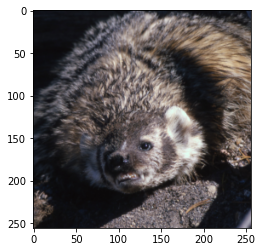

In [31]:
# importing data to calculate the means and stds
# resource: https://www.binarystudy.com/2021/04/how-to-calculate-mean-standard-deviation-images-pytorch.html
data_path = '/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/Images'

transform_img = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
])

image_data = torchvision.datasets.ImageFolder(
  root=data_path, transform=transform_img
)

image_data_loader = DataLoader(
  image_data, 
  batch_size=len(image_data), 
  shuffle=False, 
  num_workers=0
)

# Python code to visualize an image
import matplotlib.pyplot as plt

images, labels = next(iter(image_data_loader))

def display_image(images):
  images_np = images.numpy()
  img_plt = images_np.transpose(0,2,3,1)
  # display 5th image from dataset
  plt.imshow(img_plt[4])

display_image(images)

In [3]:
image_data_loader = torch.utils.data.DataLoader(
  image_data, 
  # batch size is whole datset
  batch_size=len(image_data), 
  shuffle=False, 
  num_workers=0)

def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.5683, 0.5578, 0.5178]) tensor([0.2378, 0.2437, 0.2670])


## Data Preprocessing  
- Downloading and extracting custom datasets  
- Loading custom datasets  
- Calculating the mean and std for normalization on custom datasets  
- Loading transforms to augment and normalize our data  

### **Make sure to drop grayscale images or any other odd images**

In [54]:
root = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2"

os.chdir(root)

train_path = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_data"

test_path = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/test_data"

In [64]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.5683, 0.5578, 0.5178]
std = [0.2378, 0.2437, 0.2670]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 8,
    shuffle=True
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 8,
    shuffle=True
)

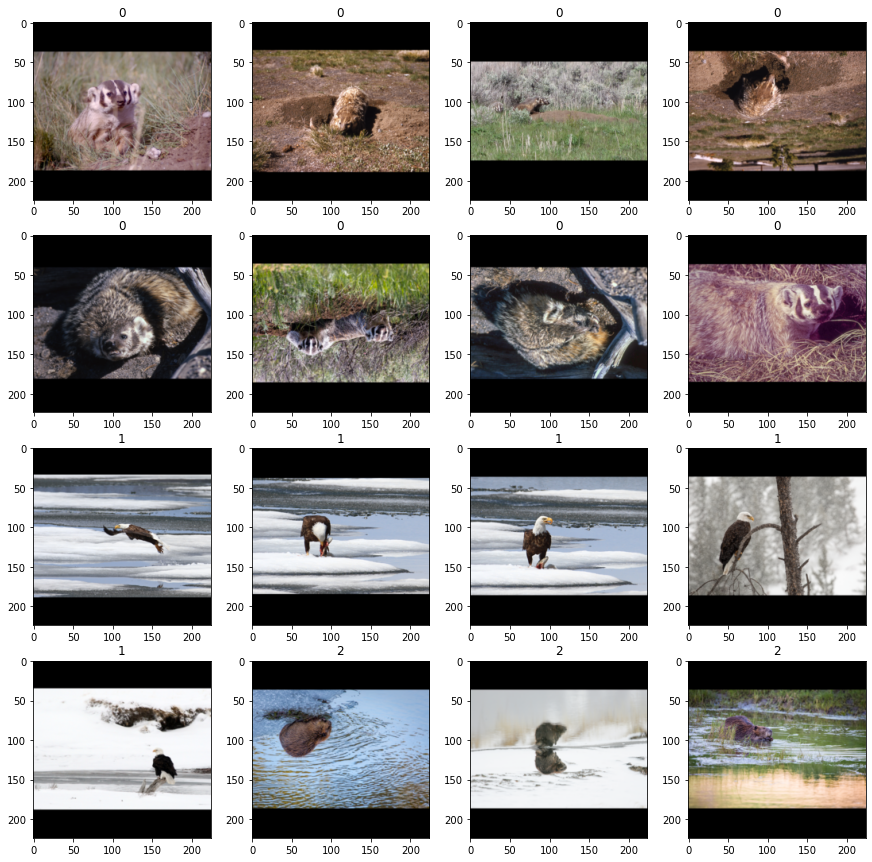

In [65]:
fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
#fig.savefig('/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_image_transformations_Project.jpg', dpi=300, bbox_inches='tight')  
#fig.savefig('/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_image_transformations_Project.png', dpi=300, bbox_inches='tight')  
plt.show()

### Define Model(ResNet34)
**We will use first 7 layers of ResNet34 model and add 2 custom FC linear layer with batch normalization as shown below**

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 15)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

cuda = False    

if torch.cuda.is_available():
  cuda = True

ResNet_34 = Net()

if cuda:
  ResNet_34.cuda()

print(ResNet_34)

Net(
  (top_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Optimizer
We will use **Adam** as our optimizer

In [67]:
optimizer = optim.SGD(params = ResNet_34.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

### Training Loop

In [68]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_34.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_34(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_34.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_34(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 1: Training Loss: NA, :   0%|                      | 0/50 [01:34<?, ?it/s]
EPOCH 50	 Batch Loss: 0.095	  Epoch Loss: 0.088	 Train Acc: 100.000	 Test Loss: 

## Model training

In [69]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

In [70]:
p = "model1_tmp.pth"
save_model(ResNet_34, str(p))
load_model(ResNet_34, str(p))

### Unfreeze the layers

In [71]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [72]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [73]:
unfreeze(ResNet_34, 7)
unfreeze(ResNet_34, 6)
unfreeze(ResNet_34, 5)

### Unfreezing few more layers

In [74]:
load_model(ResNet_34, str(p))
unfreeze(ResNet_34, 4)
unfreeze(ResNet_34, 3)
unfreeze(ResNet_34, 2)

In [75]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_34.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_34(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_34.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_34(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.095	  Epoch Loss: 0.088	 Train Acc: 100.000	 Test Loss: 
EPOCH 50	 Batch Loss: 0.013	  Epoch Loss: 0.006	 Train Acc: 100.000	 Test Loss: 

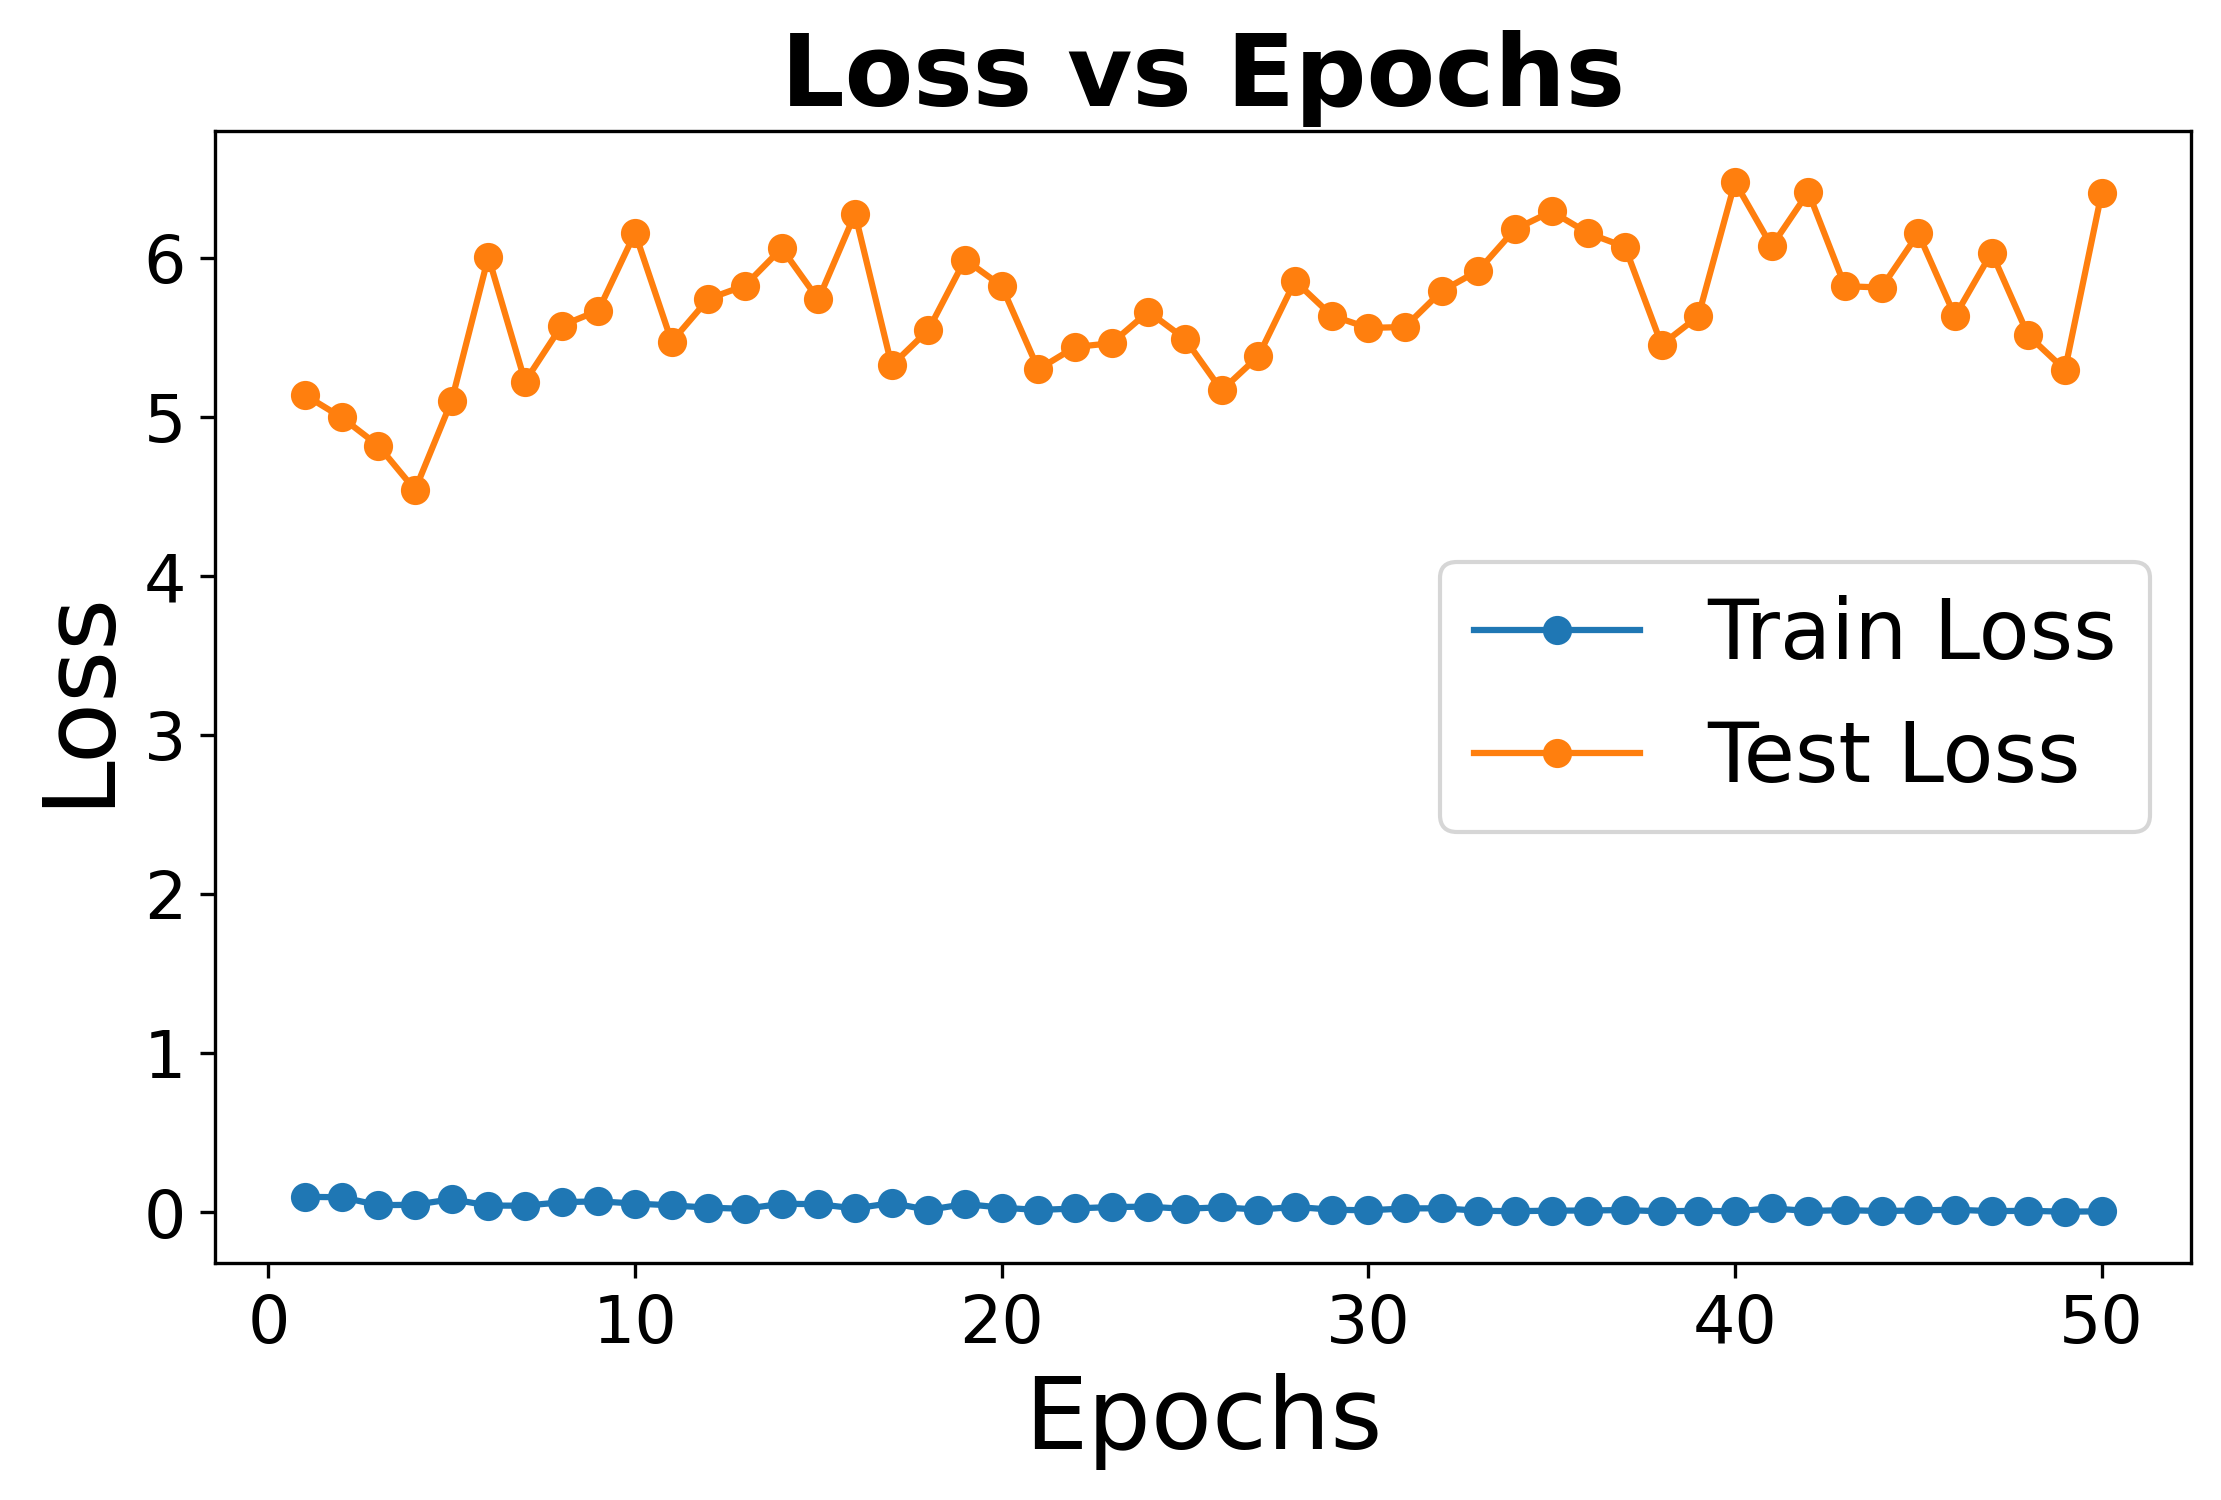

In [76]:
# from lab 8
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs_ResNet34.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs_ResNet34.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

In [77]:
x_list = x.tolist()

df = pd.DataFrame(list(zip(x_list, train_loss, test_loss)), columns =['Epoch', 'Train_Loss', "Test_Loss"])

df.to_csv('ResNet34_Loss.csv')

## Accuracy Metrics:
The code below is dervied from Pytorch github [code](https://github.com/pytorch/examples/blob/master/imagenet/main.py)

In [78]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [79]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [80]:
def calc_accuracy(model, dataloader):
    model.eval()
    #model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cpu().float(), labels.cpu().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1.avg.cpu().detach().numpy(), top5.avg.cpu().detach().numpy()

In [81]:
top1_accuracy, top5_accuracy = calc_accuracy(ResNet_34, test_loader)
print('top1 accuracy{: .2f}%, top5 accuracy{: .2f}%\n'.format(top1_accuracy, top5_accuracy))

top1 accuracy 4.55%, top5 accuracy 27.27%



In [82]:
# calculating confusion matrix
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ResNet_34.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ResNet_34(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

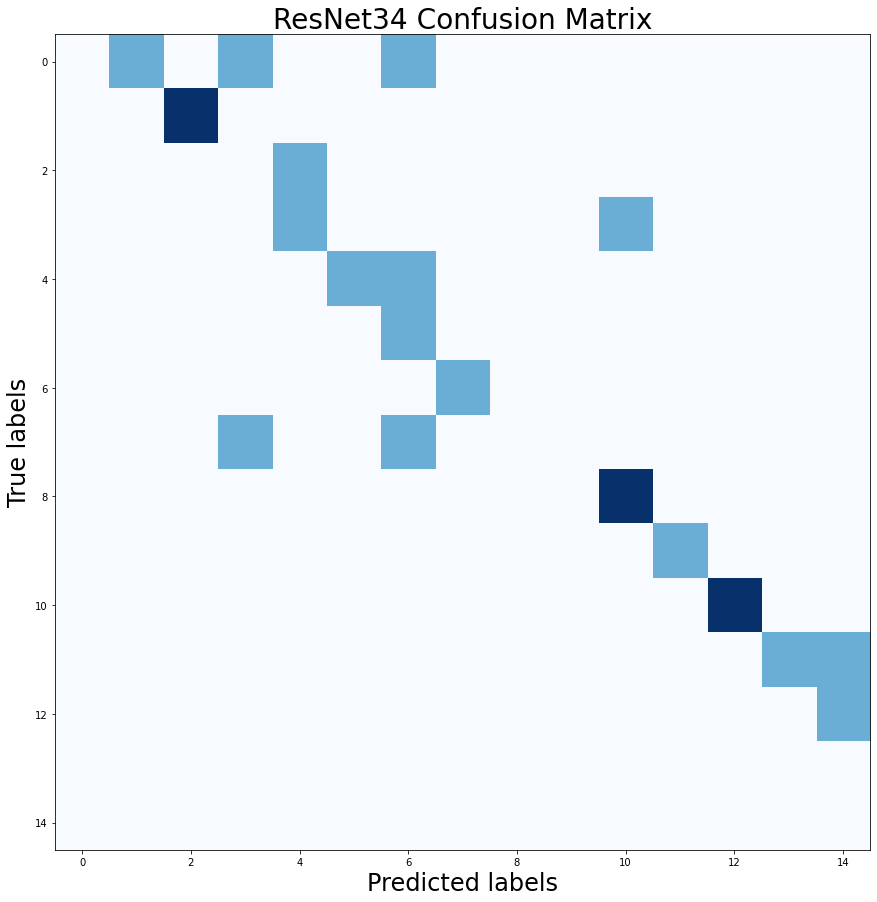

In [83]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_pred= pred, y_true = correct)

fig,ax = plt.subplots(figsize = (15,15))
plt.title('ResNet34 Confusion Matrix', fontsize = 28)
ax.set_xlabel('Predicted labels', fontsize = 24)
ax.set_ylabel('True labels', fontsize = 24)
plt.imshow(conf, interpolation='none', cmap = 'Blues')

fig.savefig("ResNet34_CM.png")

In [84]:
fig.savefig("ResNet34_CM.jpg")